# Imports

In [41]:
import os
scripts_path = os.path.abspath('../scripts')
import importlib.util
spec = importlib.util.spec_from_file_location("helpers", os.path.join(scripts_path, "helpers.py"))
helpers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(helpers)

spec = importlib.util.spec_from_file_location("nn_models", os.path.join(scripts_path, "nn_models.py"))
models = importlib.util.module_from_spec(spec)
spec.loader.exec_module(models)

import torch
from tqdm import trange

from sklearn.model_selection import train_test_split

# Neural Network

## Convert 4th down

#### Data setup

In [42]:
X_train, X_test, y_train, y_test = helpers.convert_data_split(nn=True)
X_train, X_verify, y_train, y_verify = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

batch_size = 64
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=True)

X_verify = torch.tensor(X_verify)
y_verify = torch.tensor(y_verify)

n_train, p = X_train.shape
n_verify, p = X_verify.shape

#### Testing / Training

In [44]:
def train_one_epoch(train_loader, model, optimizer, log_interval, epoch):
    model.train()
    loss_function = torch.nn.CrossEntropyLoss()
    train_loss = 0
    num_correct = 0
    
    for i, (feature, label) in enumerate(train_loader):
        feature = feature.float()
        label = label.long()

        optimizer.zero_grad()
        ans = model(feature)
        loss = loss_function(ans, label)
        loss.backward()
        optimizer.step()

        pred = ans.argmax(dim=1, keepdim=True) # Get index of largest log-probability and use that as prediction
        num_correct += (pred == label.view_as(pred)).sum().item()
        train_loss += loss.item()
    
    return train_loss, num_correct

def test_one_epoch(X_test, Y_test, model):
    model.eval()
    loss_function = torch.nn.CrossEntropyLoss()
    test_loss = 0
    num_correct = 0
    
    with torch.no_grad():
        feature = X_test.float()
        label = Y_test.long()
        output = model(feature)
        
        pred = output.argmax(dim=1, keepdim=True) # Get index of largest log-probability and use that as prediction
        num_correct += (pred == label.view_as(pred)).sum().item()
        test_loss += torch.nn.functional.nll_loss(output, label.long(), reduction='sum').item()

    return test_loss, num_correct

#### Running

In [45]:
# Hyperparameters
lr = 0.001
wd = 0.01
max_epochs = 350

# Print results
log_interval = 20

model = models.ConvertNNClassifier()

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

train_losses = []
train_correct_list = []
test_losses = []
test_correct_list = []

for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    train_loss, train_correct = train_one_epoch(train_loader, model, optimizer, log_interval, epoch)
    
    if epoch % log_interval == 0:
        test_loss, test_correct = test_one_epoch(X_verify, y_verify, model)

        # Record results
        train_losses.append(train_loss)
        train_correct_list.append(train_correct)
        test_losses.append(test_loss)
        test_correct_list.append(test_correct)
        
        print('cross entropy loss', train_loss / len(train_loader), test_loss / float(n_verify))
        print('accuracy', train_correct / float(n_train), test_correct / float(n_verify))

torch.save(model.state_dict(), '../models/nn/convert.joblib')

Epochs:   0%|          | 0/350 [00:00<?, ?it/s]/var/folders/8r/q18lgzp95917cyrn8bqmq1c80000gn/T/ipykernel_70949/1390969298.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_output = self.log_softmax(x)
Epochs:   0%|          | 1/350 [00:02<14:57,  2.57s/it]

cross entropy loss 1.27483948216092 1.2364554211078105
accuracy 0.5684389881602516 0.6044032849903896


Epochs:   6%|▌         | 21/350 [00:44<11:09,  2.03s/it]

cross entropy loss 0.6351153266163512 0.6486417966019788
accuracy 0.8147144916772249 0.8067447143106762


Epochs:  12%|█▏        | 41/350 [01:25<10:45,  2.09s/it]

cross entropy loss 0.5607720019930568 0.5762356936921195
accuracy 0.8245882301542226 0.8167045255984623


Epochs:  17%|█▋        | 61/350 [02:06<09:59,  2.08s/it]

cross entropy loss 0.540211591723911 0.5553099028863795
accuracy 0.8255057014286339 0.8193255285689324


Epochs:  23%|██▎       | 81/350 [02:48<09:16,  2.07s/it]

cross entropy loss 0.5288491115057269 0.5438282546850428
accuracy 0.8257678360784656 0.8196749956316617


Epochs:  29%|██▉       | 101/350 [03:27<07:50,  1.89s/it]

cross entropy loss 0.5207627028559839 0.5357786528863795
accuracy 0.8286076281183101 0.8214223309453084


Epochs:  35%|███▍      | 121/350 [04:07<07:47,  2.04s/it]

cross entropy loss 0.5141851793787333 0.5292925237255373
accuracy 0.8305299488837433 0.8245675345098724


Epochs:  40%|████      | 141/350 [04:49<07:12,  2.07s/it]

cross entropy loss 0.5083508048643613 0.5235496946258519
accuracy 0.8321901349993447 0.8266643368862485


Epochs:  46%|████▌     | 161/350 [05:32<06:59,  2.22s/it]

cross entropy loss 0.502837911123337 0.518179923322012
accuracy 0.8338503211149461 0.8268390704176132


Epochs:  52%|█████▏    | 181/350 [06:14<06:09,  2.18s/it]

cross entropy loss 0.4976990946344823 0.513227959685698
accuracy 0.8349425488225786 0.8275380045430718


Epochs:  57%|█████▋    | 201/350 [06:57<05:21,  2.16s/it]

cross entropy loss 0.4929298554552334 0.5086341230014852
accuracy 0.8356852636637686 0.8282369386685305


Epochs:  63%|██████▎   | 221/350 [07:40<04:21,  2.03s/it]

cross entropy loss 0.4884894661313995 0.5043483309534991
accuracy 0.8358600200969898 0.8296348069194478


Epochs:  69%|██████▉   | 241/350 [08:22<03:39,  2.01s/it]

cross entropy loss 0.48436920989991566 0.5003493817436222
accuracy 0.8364279785049588 0.8306832081076359


Epochs:  75%|███████▍  | 261/350 [09:04<03:05,  2.09s/it]

cross entropy loss 0.4805315812040308 0.49659909507142236
accuracy 0.8375638953208965 0.8322558098899179


Epochs:  80%|████████  | 281/350 [09:45<02:25,  2.11s/it]

cross entropy loss 0.4769113496695151 0.49305941861512753
accuracy 0.8378697190790336 0.8329547440153765


Epochs:  86%|████████▌ | 301/350 [10:27<01:40,  2.04s/it]

cross entropy loss 0.47353913664151837 0.4897975411715883
accuracy 0.8387435012451396 0.8338284116721999


Epochs:  92%|█████████▏| 321/350 [11:10<00:59,  2.05s/it]

cross entropy loss 0.4705121711978699 0.48686781101203475
accuracy 0.8390056358949713 0.8336536781408352


Epochs:  97%|█████████▋| 341/350 [11:53<00:18,  2.05s/it]

cross entropy loss 0.46777410821874715 0.48418768190033634
accuracy 0.839398837869719 0.8340031452035646


Epochs: 100%|██████████| 350/350 [12:13<00:00,  2.10s/it]


#### Results

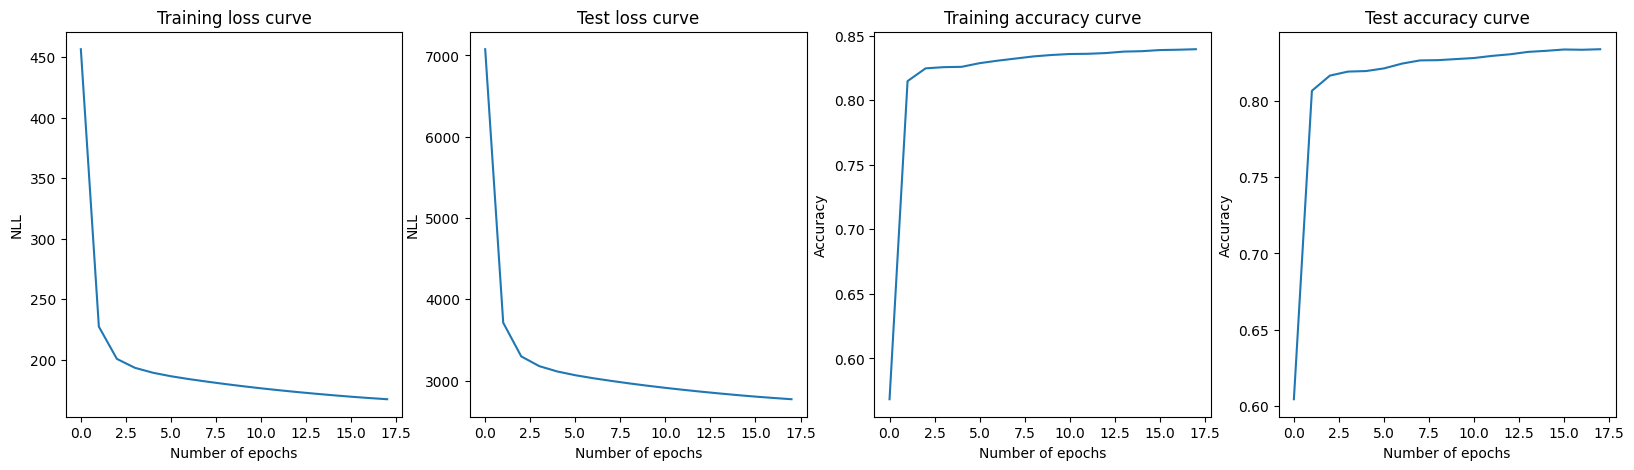

In [46]:
from matplotlib import pyplot

fig, axes = pyplot.subplots(ncols=4, figsize=(20, 5), sharey=False)

axes[0].set_xlabel('Number of epochs')
axes[0].set_ylabel('NLL')
axes[0].plot(range(0,len(train_losses)), train_losses)
axes[0].set_title('Training loss curve')

axes[1].set_xlabel('Number of epochs')
axes[1].set_ylabel('NLL')
axes[1].plot(range(0,len(train_losses)), test_losses)
axes[1].set_title('Test loss curve')

axes[2].set_xlabel('Number of epochs')
axes[2].set_ylabel('Accuracy')
axes[2].plot(range(0,len(train_losses)), list(map(lambda x : x/float(n_train), train_correct_list)))
axes[2].set_title('Training accuracy curve')

axes[3].set_xlabel('Number of epochs')
axes[3].set_ylabel('Accuracy')
axes[3].plot(range(0,len(train_losses)), list(map(lambda x : x/float(n_verify), test_correct_list)))
axes[3].set_title('Test accuracy curve')
pyplot.show()

## Attempt 4th down

#### Data setup

In [47]:
X_train, X_test, y_train, y_test = helpers.attempt_data_split(nn=True)
X_train, X_verify, y_train, y_verify = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

batch_size = 64
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=True)

X_verify = torch.tensor(X_verify)
y_verify = torch.tensor(y_verify)

n_train, p = X_train.shape
n_verify, p = X_verify.shape

#### Testing / Training

In [49]:
def train_one_epoch(train_loader, model, optimizer, log_interval, epoch):
    model.train()
    loss_function = torch.nn.CrossEntropyLoss()
    train_loss = 0
    num_correct = 0
    
    for i, (feature, label) in enumerate(train_loader):
        feature = feature.float()
        label = label.long()

        optimizer.zero_grad()
        ans = model(feature)
        loss = loss_function(ans, label)
        loss.backward()
        optimizer.step()

        pred = ans.argmax(dim=1, keepdim=True) # Get index of largest log-probability and use that as prediction
        num_correct += (pred == label.view_as(pred)).sum().item()
        train_loss += loss.item()
    
    return train_loss, num_correct

def test_one_epoch(X_test, Y_test, model):
    model.eval()
    loss_function = torch.nn.CrossEntropyLoss()
    test_loss = 0
    num_correct = 0
    
    with torch.no_grad():
        feature = X_test.float()
        label = Y_test.long()
        output = model(feature)
        
        pred = output.argmax(dim=1, keepdim=True) # Get index of largest log-probability and use that as prediction
        num_correct += (pred == label.view_as(pred)).sum().item()
        test_loss += torch.nn.functional.nll_loss(output, label.long(), reduction='sum').item()

    return test_loss, num_correct

#### Running

In [50]:
# Hyperparameters
lr = 0.001
wd = 0.01
max_epochs = 350

# Print results
log_interval = 20

model = models.AttemptNNClassifier()

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

train_losses = []
train_correct_list = []
test_losses = []
test_correct_list = []

for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    train_loss, train_correct = train_one_epoch(train_loader, model, optimizer, log_interval, epoch)
    
    if epoch % log_interval == 0:
        test_loss, test_correct = test_one_epoch(X_verify, y_verify, model)

        # Record results
        train_losses.append(train_loss)
        train_correct_list.append(train_correct)
        test_losses.append(test_loss)
        test_correct_list.append(test_correct)
        
        print('cross entropy loss', train_loss / len(train_loader), test_loss / float(n_verify))
        print('accuracy', train_correct / float(n_train), test_correct / float(n_verify))

torch.save(model.state_dict(), '../models/nn/attempt.joblib')

Epochs:   0%|          | 0/350 [00:00<?, ?it/s]/var/folders/8r/q18lgzp95917cyrn8bqmq1c80000gn/T/ipykernel_70949/1669133810.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_output = self.log_softmax(x)
Epochs:   0%|          | 1/350 [00:02<14:34,  2.51s/it]

cross entropy loss 1.0488304612356858 1.0269573397638914
accuracy 0.5025995019441654 0.6044032849903896


Epochs:   6%|▌         | 21/350 [00:41<11:29,  2.10s/it]

cross entropy loss 0.5772092478901314 0.5806548821640748
accuracy 0.8081611254314299 0.8013279748383715


Epochs:  12%|█▏        | 41/350 [01:22<10:27,  2.03s/it]

cross entropy loss 0.4522214268006426 0.459301122185152
accuracy 0.8372580715627594 0.8343526122662939


Epochs:  17%|█▋        | 61/350 [02:01<09:10,  1.90s/it]

cross entropy loss 0.41788442978146356 0.4250291194112572
accuracy 0.8449036655161868 0.84169142058361


Epochs:  23%|██▎       | 81/350 [02:39<08:26,  1.88s/it]

cross entropy loss 0.3998860941169648 0.4076933006754543
accuracy 0.8526366376862248 0.8481565612441028


Epochs:  29%|██▉       | 101/350 [03:17<07:46,  1.87s/it]

cross entropy loss 0.38873741642556375 0.39720421230670105
accuracy 0.8577482633579449 0.8520006989341254


Epochs:  35%|███▍      | 121/350 [03:54<07:20,  1.92s/it]

cross entropy loss 0.3809173433474322 0.38977279009861526
accuracy 0.8600200969898204 0.8533985671850428


Epochs:  40%|████      | 141/350 [04:33<06:44,  1.94s/it]

cross entropy loss 0.375014351025307 0.38390317680576186
accuracy 0.8619861068635589 0.8546217019045955


Epochs:  46%|████▌     | 161/350 [05:16<07:03,  2.24s/it]

cross entropy loss 0.37011973984414637 0.37887250629313735
accuracy 0.8630783345711914 0.8560195701555129


Epochs:  52%|█████▏    | 181/350 [06:01<06:10,  2.19s/it]

cross entropy loss 0.365834352066064 0.37443028166226194
accuracy 0.8641268731705186 0.8574174384064301


Epochs:  57%|█████▋    | 201/350 [06:44<05:38,  2.27s/it]

cross entropy loss 0.36207829295090455 0.3705099540095885
accuracy 0.8649569662283193 0.8572427048750655


Epochs:  63%|██████▎   | 221/350 [07:29<04:37,  2.15s/it]

cross entropy loss 0.3589193616166461 0.36717615255875413
accuracy 0.8652627899864563 0.8584658395946182


Epochs:  69%|██████▉   | 241/350 [08:13<04:10,  2.29s/it]

cross entropy loss 0.3563182411829853 0.3644729019690285
accuracy 0.8656123028528988 0.8589900401887122


Epochs:  75%|███████▍  | 261/350 [08:59<03:24,  2.29s/it]

cross entropy loss 0.3541746490411252 0.362300464204198
accuracy 0.866223950369173 0.8593395072514416


Epochs:  80%|████████  | 281/350 [09:42<02:31,  2.19s/it]

cross entropy loss 0.35238894295759043 0.36053653432421806
accuracy 0.8667919087771419 0.8600384413769002


Epochs:  86%|████████▌ | 301/350 [10:25<01:42,  2.10s/it]

cross entropy loss 0.35087492841415563 0.3590762978060021
accuracy 0.8673161780768055 0.8612615760964529


Epochs:  92%|█████████▏| 321/350 [11:10<01:09,  2.40s/it]

cross entropy loss 0.34959499862606963 0.35782982831065435
accuracy 0.8674909345100267 0.8617857766905469


Epochs:  97%|█████████▋| 341/350 [11:55<00:21,  2.42s/it]

cross entropy loss 0.34850696457664393 0.35673612267659005
accuracy 0.8677530691598584 0.862834177878735


Epochs: 100%|██████████| 350/350 [12:14<00:00,  2.10s/it]


#### Results

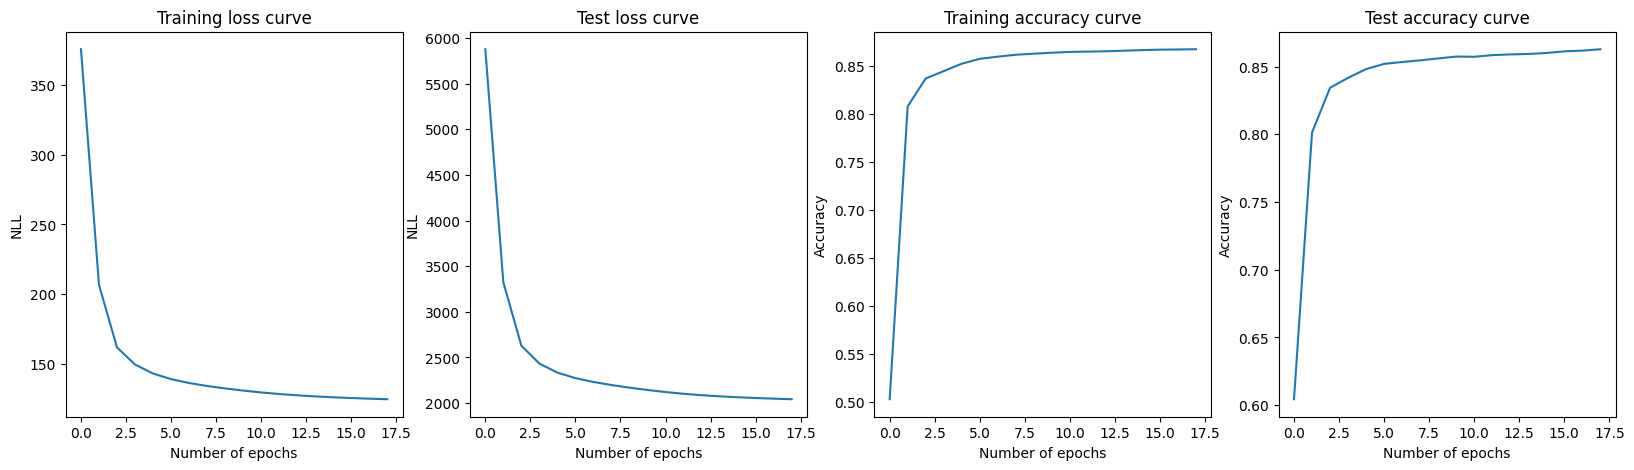

In [51]:
from matplotlib import pyplot

fig, axes = pyplot.subplots(ncols=4, figsize=(20, 5), sharey=False)

axes[0].set_xlabel('Number of epochs')
axes[0].set_ylabel('NLL')
axes[0].plot(range(0,len(train_losses)), train_losses)
axes[0].set_title('Training loss curve')

axes[1].set_xlabel('Number of epochs')
axes[1].set_ylabel('NLL')
axes[1].plot(range(0,len(train_losses)), test_losses)
axes[1].set_title('Test loss curve')

axes[2].set_xlabel('Number of epochs')
axes[2].set_ylabel('Accuracy')
axes[2].plot(range(0,len(train_losses)), list(map(lambda x : x/float(n_train), train_correct_list)))
axes[2].set_title('Training accuracy curve')

axes[3].set_xlabel('Number of epochs')
axes[3].set_ylabel('Accuracy')
axes[3].plot(range(0,len(train_losses)), list(map(lambda x : x/float(n_verify), test_correct_list)))
axes[3].set_title('Test accuracy curve')
pyplot.show()